In [284]:
'''

Model created based on an existing model, made by Rocher Smol.
This model can be found in this same VPN.

WORKING ON: file/folder management; let everything happen in ./Run

'''

'\n\nModel created based on an existing model, made by Rocher Smol.\nThis model can be found in this same VPN.\n\nWORKING ON: file/folder management; let everything happen in ./Run\n\n'

In [285]:
# Import the important stuff:

import sys
import csv
import os
import shutil
import pandas as pd
import numpy as np
import decimal
from pyneuroml import pynml
from pyneuroml.pynml import print_comment_v
from pyneuroml.lems import LEMSSimulation

import neuroml as nml
import neuroml.writers as writers
from neuroml.utils import validate_neuroml2
import random
random.seed(12345)
from neuroml.nml.nml import parse as nmlparse
import eden_tools
dir(eden_tools)

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
os.getcwd()

'/home/jovyan/work/Users/Ward/Temperature_invest'

In [374]:
# Initiating the simulation details and credentials:
'''

Note that this code is the part where we can change the variables that we want to change.
Make sure to run it after doing so.

'''

def initiate():
    #print(os.ctermid())
    
    sim_id = 'Test'
    length = 5000
    step = 0.025
    sim_length = [length,step] #Simulation length and step size, in ms

    path = os.getcwd()
    Temps = [34.0,34.1,34.2,34.3,34.4,34.5,34.6,34.7,34.8,34.9,35.0] #degC 
    #in an array so that it becomes easy to modify later :)

    nml_cell_file = 'C51A_scaled_exp_resample_5.cell.nml' #enter the cell file in here. This file needs to be in the Cells folder.
    cell_id = nml_cell_file.split('/')[-1].split('_')[0]
    
    results = []

    #print(sim_id,path,Temps,nml_cell_file,cell_id,results)
    return sim_id,path,Temps,nml_cell_file,cell_id,results,sim_length

In [287]:
# Cleaning up the directory from previous runs:

def clean(sim_id,cell_id):
    open('./pynmlNetworks/nml_%s.net.nml'%cell_id, 'a').close()
    open('./LEMSFILES/LEMS_%s_%s.xml'%(sim_id,cell_id), 'a').close()
    os.remove('./pynmlNetworks/nml_%s.net.nml'%cell_id)
    os.remove('./LEMSFILES/LEMS_%s_%s.xml'%(sim_id,cell_id))
    l = os.listdir('./Run')
    #print(l)
    if l != []:
        for name in l:
            if name != '.ipynb_checkpoints':
                os.remove('./Run/%s'%name)
            

In [288]:
# Creating a network given the specific files:

#Needed: path,cell_id, nml_cell_file,Temp
def create_net(path,cell_id,nml_cell_file,Temp):

    shutil.copy(path+'/Cells/'+str(nml_cell_file), path+'/Run')
    
    # This following piece of code was intended to make user experience better
    '''
    doc = nmlparse(path+'/Run/'+str(nml_cell_file))
    cellincludes = doc.includes
    newincludes = []
    correct = True
    for incl in cellincludes:
        correct = True
        if incl.contains('.channel.nml'):
            if incl.contains('../channels/'):
                incl = incl
            elif incl.contains('/channels/'):
                # Find where [...]/channels/[...] is located, and replace everything before it by ../channels/
            else:
                incl = '../channels/'+incl
        newincludes.append(incl)
    doc.includes = newincludes
    '''
        
    net_id = 'network_of_%s'%cell_id
    net_doc = nml.NeuroMLDocument(id='net_%s'%cell_id) # Create a document to store the network

    # Include a cell
    cellfile = nml.IncludeType(href='../Run/'+nml_cell_file)
    net_doc.includes.append(cellfile)

    # Include a network
    net = nml.Network(id=net_id,type='networkWithTemperature',temperature=str(Temp)+'degC')
    net_doc.networks.append(net)

    # Include a population
    pop = nml.Population(id='population_of_%s'%cell_id,component=cell_id,type='populationList',size='1')
    net.populations.append(pop)

    # Place population
    loc = nml.Location(x='0',y='0',z='0')
    inst = nml.Instance(id='0',location=loc)
    pop.instances.append(inst)
    
    return net_id,net_doc,net,pop

In [289]:
# Include simulation instructions:

#Needed: net_doc,pop,cell_id,net
def enter_instructions(cell_id,net_doc,net,pop):
    
    t_delay = 1000
    t_duration = 10
    Amp = '-0nA' #negative current
    
    # Create 5 identical clamp proxies
    Iclamp0 = nml.PulseGenerator(id='iclamp0',delay=str(t_delay)+'ms',duration=str(t_duration)+'ms',amplitude=Amp)
    net_doc.pulse_generators.append(Iclamp0)
    
    Iclamp1 = nml.PulseGenerator(id='iclamp1',delay=str(t_delay)+'ms',duration=str(t_duration)+'ms',amplitude=Amp)
    net_doc.pulse_generators.append(Iclamp1)
    
    Iclamp2 = nml.PulseGenerator(id='iclamp2',delay=str(t_delay)+'ms',duration=str(t_duration)+'ms',amplitude=Amp)
    net_doc.pulse_generators.append(Iclamp2)
    
    Iclamp3 = nml.PulseGenerator(id='iclamp3',delay=str(t_delay)+'ms',duration=str(t_duration)+'ms',amplitude=Amp)
    net_doc.pulse_generators.append(Iclamp3)
    
    Iclamp4 = nml.PulseGenerator(id='iclamp4',delay=str(t_delay)+'ms',duration=str(t_duration)+'ms',amplitude=Amp)
    net_doc.pulse_generators.append(Iclamp4)
    
    
    # Induce these clamps in different segments:
    input_list = nml.InputList(id='Iclamp0',component=Iclamp0.id,populations=pop.id)
    input = nml.Input(id='0',target="../%s/0/"%(pop.id)+str(cell_id), segment_id="0",fractionAlong="0.5", destination="synapses")
    input_list.input.append(input)
    net.input_lists.append(input_list)
    
    return net_doc,net

In [290]:
# Write and redefine the network file:

def write_net(path,cell_id,net_doc):
    net_file_name = 'nml_%s.net.nml'%cell_id
    writers.NeuroMLWriter.write(net_doc,net_file_name)
    shutil.move(path+'/'+str(net_file_name), path+'/pynmlNetworks')
    shutil.copy(path+'/pynmlNetworks/'+str(net_file_name), path+'/Run')
    validate_neuroml2('./Run/nml_'+cell_id+'.net.nml')
    

In [291]:
# Write the LEMS file:

#Needed: cell_id,pop,sim_id,path
def write_LEMS(path,sim_id,cell_id,pop,sim_length):
    
    # Redefine net
    sim_id = 'Test'
    length = sim_length[0] # ms
    step = sim_length[1]
    
    # Write LEMS records
    soma_channel = ["na_s_soma/na_s/m/q", "na_s_soma/na_s/h/q", "kdr_soma/kdr/n/q", "k_soma/k/n/q", "cal_soma/cal/k/q", "cal_soma/cal/l/q", "BK_soma/BK/c/q"]
    recorded_segment = 0
    recorded_segment1 = 10
    recorded_segment2 = 69
    recorded_segment3 = 0
    recorded_variable1 = "%s/0/"%(pop.id)+str(cell_id)+"/"+str(recorded_segment1)+"/v"
    recorded_variable2 = "%s/0/"%(pop.id)+str(cell_id)+"/"+str(recorded_segment2)+"/v"
    recorded_variable3 = "%s/0/"%(pop.id)+str(cell_id)+"/"+str(recorded_segment3)+"/v"
    
    # Create LEMS:
    nmlfile = './Run/nml_'+cell_id+'.net.nml'
    LEMS = LEMSSimulation(sim_id,length,step,target='network_of_%s'%cell_id)
    LEMS.include_neuroml2_file(nmlfile)
    LEMS.set_report_file('SimStat_%s_%s.txt'%(sim_id,cell_id)) 
    
    
    disp1 = 'Gates Dendrite'
    disp2 = 'Gates Axon'
    disp = 'Gates Soma'
    traces1 = 'Gate_file_dendrite'
    traces2 = 'Gate_file_axon'
    traces = 'Gate_file_soma'

    LEMS.create_display(disp, "Soma gate variables", "0", "1")
    LEMS.create_output_file(traces, "%s.Soma_gates.dat"%sim_id)
    
    disp4 = 'Soma Voltage'
    LEMS.create_display(disp4, "Dendrite trace", "-100", "70")
    LEMS.add_line_to_display(disp4, recorded_segment3, recorded_variable3)
    
    traces4 = 'Soma file'
    LEMS.create_output_file(traces4, "%s.vd.dat"%cell_id)
    LEMS.add_column_to_output_file(traces4, recorded_segment3, recorded_variable3)
    
    disp5 = 'Caconc'
    LEMS.create_display(disp5, "Caconc trace", "-100", "70")
    LEMS.add_line_to_display(disp5, recorded_segment1, "%s/0/"%(pop.id)+str(cell_id)+"/"+str(140)+"/caConc")

    traces5 = 'Caconc file'
    LEMS.create_output_file(traces5, "%s.caconc.dat"%sim_id)
    LEMS.add_column_to_output_file(traces5, recorded_segment1, "%s/0/"%(pop.id)+str(cell_id)+"/"+str(140)+"/caConc")
    
    
    filename = 'LEMS_'+str(sim_id)+'_'+str(cell_id)+'.xml'
    LEMS.save_to_file(file_name = filename )

    #edit the wrong path generated by LEMS.include_neuroml2_file
    fin = open(path+'/'+str(filename), 'rt')
    data = fin.read()
    data = data.replace('<Include file="./pynmlNetworks/', '<Include file="../Run/')
    data = data.replace('<Include file="./Run/', '<Include file="../Run/')
    data = data.replace('ExpTime.nml', '../channels/ExpTime.nml')    # patch up for wrong path generated in network script
    fin.close()
    fin = open(path+'/'+str(filename), 'wt')
    fin.write(data)
    fin.close()

    shutil.move(path+'/'+str(filename), path+'/LEMSFILES')
    shutil.copy(path+'/LEMSFILES/'+str(filename), path+'/Run')
    
    # RETURN????

In [292]:
# Setting up the experiment and then running it

#Needed: sim_id,cell_id,nml_cell_file
def setup_and_run(sim_id,cell_id,nml_cell_file,Temp):
    channel_dict = dict(na_s_soma=0, kdr_soma=1, k_soma=2, cal_soma=3, BK_soma=4, cah_dend=5, kca_dend=6, h_dend=7, cacc_dend=8, na_axon=9, k_axon=10)
    #results = []
    #parameter = []

    parameter = 0.0
    chosen_channel = 'cacc_dend'
    #results = []
    
    
    # Set parameters:
    na_s_soma =[30]   #default 30    30
    kdr_soma=[30]    #default 30     30
    k_soma=[15]      #default 15     15
    cal_soma=[30] #default 30        30
    BK_soma=[0] #default 0 :)        0

    #set dendritic channel densities
    cah_dend=[10]   #default 10       9
    kca_dend=[220]   #default 200    220
    h_dend=[25]       #default 25    35
    cacc_dend = [0] #default 0.7     6

    #set axonic channel densities
    na_axon=[200]     #default 200   250
    k_axon=[200]      #default 200   800
    
    #parameters for the ca model
    initial_ca_concentration = 3.7152
    initial_exterior_ca_concentration = 3.0
    
    
    # Start the experiment!
        
    filename = 'LEMS_%s_%s.xml'%(sim_id,cell_id)
    LEMS_file = f'LEMSFILES/{filename}'
    LEMS_file_use = f'Run/{filename}'
    doc = nmlparse('./Run/'+nml_cell_file)

    #somatic channel densities
    doc.cells[0].biophysical_properties.membrane_properties.channel_densities[channel_dict['na_s_soma']].cond_density = str(na_s_soma[0])+' mS_per_cm2'
    doc.cells[0].biophysical_properties.membrane_properties.channel_densities[channel_dict['kdr_soma']].cond_density = str(kdr_soma[0])+' mS_per_cm2'
    doc.cells[0].biophysical_properties.membrane_properties.channel_densities[channel_dict['k_soma']].cond_density = str(k_soma[0])+' mS_per_cm2'
    doc.cells[0].biophysical_properties.membrane_properties.channel_densities[channel_dict['cal_soma']].cond_density = str(cal_soma[0])+' mS_per_cm2'
    doc.cells[0].biophysical_properties.membrane_properties.channel_densities[channel_dict['BK_soma']].cond_density = str(BK_soma[0])+' mS_per_cm2'

    #dendritic channel densities    
    doc.cells[0].biophysical_properties.membrane_properties.channel_densities[channel_dict['cah_dend']].cond_density = str(cah_dend[0])+' mS_per_cm2'
    doc.cells[0].biophysical_properties.membrane_properties.channel_densities[channel_dict['kca_dend']].cond_density = str(kca_dend[0])+' mS_per_cm2'    
    doc.cells[0].biophysical_properties.membrane_properties.channel_densities[channel_dict['h_dend']].cond_density = str(h_dend[0])+' mS_per_cm2'
    doc.cells[0].biophysical_properties.membrane_properties.channel_densities[channel_dict['cacc_dend']].cond_density = str(cacc_dend[0])+' mS_per_cm2'

    #axonic channel densities
    doc.cells[0].biophysical_properties.membrane_properties.channel_densities[channel_dict['na_axon']].cond_density = str(na_axon[0])+' mS_per_cm2'
    doc.cells[0].biophysical_properties.membrane_properties.channel_densities[channel_dict['k_axon']].cond_density = str(k_axon[0])+' mS_per_cm2'
    
    calcium_model = nml.Species(id="ca",concentration_model="ca_conc",ion="ca",initial_concentration=str(initial_ca_concentration)+' mM',initial_ext_concentration=str(initial_exterior_ca_concentration)+' mM')
    doc.cells[0].biophysical_properties.intracellular_properties.species.append(calcium_model)

    # Write the file
    writers.NeuroMLWriter.write(doc, 'Cells/'+cell_id+'_scaled_exp_resample_5.cell.nml')
    writers.NeuroMLWriter.write(doc, 'Run/'+cell_id+'_scaled_exp_resample_5.cell.nml')
    
    # Control
    out_dir,rel_filename = os.path.split(LEMS_file_use)
    #print(out_dir)
    #print(rel_filename)
    
    print(f'You are running a simulation of {LEMS_file_use} at {Temp} degrees and saving the results to your current directory.\n')
    
    # RUN!
    #print("Start: %s using Eden"%LEMS_file_use)
    results_Eden = eden_tools.runEden( LEMS_file_use, verbose=True )
    return results_Eden
    
    #print("Start: %s using Neuron"%LEMS_file_use)
    #results_Neuron = eden_tools.runNeuron( LEMS_file_use, verbose=False )
    #return results_Neuron

In [376]:
# Plotting the results:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

def plot(results,Temps,sim_length):
    # Use step size to determine these numbers
    starttime = 0 #ms
    endtime = 200 #ms
    
    start = int(starttime*(round(1/sim_length[1])))
    end = int(endtime*(round(1/sim_length[1])))
    
    for i in range(len(results)):
        Temp = Temps[i]
        print(color.BOLD + "Temperature: %s"%Temp + color.END)
        
        results_Neuron = results[i]
        results_Neuron['t'] = [x*1000 for x in results_Neuron['t']]
        
        for key in results[i]:
            if key == 't':
                continue
            plt.plot(results_Neuron['t'][start:end],results_Neuron[key][start:end], label=""+key)
            plt.xlabel("Time (ms)")
            plt.ylabel(key)
            plt.grid(True)
            plt.legend(loc='upper right')
            plt.show()
        

In [377]:
# Main code:

def main():
    sim_id,path,Temps,nml_cell_file,cell_id,results,sim_length = initiate()
    #print("Initiated!")
    clean(sim_id,cell_id)
    #print("Cleaned!")
    for Temp in Temps:
        net_id,net_doc,net,pop = create_net(path,cell_id,nml_cell_file,Temp)
        #print("Net created!")
        net_doc,net = enter_instructions(cell_id,net_doc,net,pop)
        #print("Instructions entered!")
        write_net(path,cell_id,net_doc)
        #print("Net file written!")
        write_LEMS(path,sim_id,cell_id,pop,sim_length)
        #print("LEMS file written!")
        results_Neuron = setup_and_run(sim_id,cell_id,nml_cell_file,Temp)
        #print("Ran!")
        results.append(dict(results_Neuron))
        
        if Temp != Temps[-1]:
            clean(sim_id,cell_id)
    plot(results,Temps,sim_length)

Validating ./Run/nml_C51A.net.nml against /opt/conda/lib/python3.7/site-packages/neuroml/nml/NeuroML_v2.1.xsd
It's valid!
pyNeuroML >>> Written LEMS Simulation Test to file: LEMS_Test_C51A.xml
You are running a simulation of Run/LEMS_Test_C51A.xml at 34.0 degrees and saving the results to your current directory.

['eden', 'nml', 'Run/LEMS_Test_C51A.xml', 'gcc']


/opt/conda/lib/python3.7/site-packages/pkg_resources/__init__.py:1135: DeprecationWarning: Use of .. or absolute path in a resource path is not allowed and will raise exceptions in a future release.
  return get_provider(package_or_requirement).has_resource(resource_name)


Ran EDEN in 1.60 seconds
pyNeuroML >>> Reloading data specified in LEMS file: Run/LEMS_Test_C51A.xml (/home/jovyan/work/Users/Ward/Temperature_invest/Run/LEMS_Test_C51A.xml), base_dir: ., cwd: /home/jovyan/work/Users/Ward/Temperature_invest; plotting True
Validating ./Run/nml_C51A.net.nml against /opt/conda/lib/python3.7/site-packages/neuroml/nml/NeuroML_v2.1.xsd
It's valid!
pyNeuroML >>> Written LEMS Simulation Test to file: LEMS_Test_C51A.xml
You are running a simulation of Run/LEMS_Test_C51A.xml at 34.1 degrees and saving the results to your current directory.

['eden', 'nml', 'Run/LEMS_Test_C51A.xml', 'gcc']


/opt/conda/lib/python3.7/site-packages/pkg_resources/__init__.py:1135: DeprecationWarning: Use of .. or absolute path in a resource path is not allowed and will raise exceptions in a future release.
  return get_provider(package_or_requirement).has_resource(resource_name)


Ran EDEN in 1.61 seconds
pyNeuroML >>> Reloading data specified in LEMS file: Run/LEMS_Test_C51A.xml (/home/jovyan/work/Users/Ward/Temperature_invest/Run/LEMS_Test_C51A.xml), base_dir: ., cwd: /home/jovyan/work/Users/Ward/Temperature_invest; plotting True
Validating ./Run/nml_C51A.net.nml against /opt/conda/lib/python3.7/site-packages/neuroml/nml/NeuroML_v2.1.xsd
It's valid!
pyNeuroML >>> Written LEMS Simulation Test to file: LEMS_Test_C51A.xml
You are running a simulation of Run/LEMS_Test_C51A.xml at 34.2 degrees and saving the results to your current directory.

['eden', 'nml', 'Run/LEMS_Test_C51A.xml', 'gcc']


/opt/conda/lib/python3.7/site-packages/pkg_resources/__init__.py:1135: DeprecationWarning: Use of .. or absolute path in a resource path is not allowed and will raise exceptions in a future release.
  return get_provider(package_or_requirement).has_resource(resource_name)


Ran EDEN in 1.64 seconds
pyNeuroML >>> Reloading data specified in LEMS file: Run/LEMS_Test_C51A.xml (/home/jovyan/work/Users/Ward/Temperature_invest/Run/LEMS_Test_C51A.xml), base_dir: ., cwd: /home/jovyan/work/Users/Ward/Temperature_invest; plotting True
Validating ./Run/nml_C51A.net.nml against /opt/conda/lib/python3.7/site-packages/neuroml/nml/NeuroML_v2.1.xsd
It's valid!
pyNeuroML >>> Written LEMS Simulation Test to file: LEMS_Test_C51A.xml
You are running a simulation of Run/LEMS_Test_C51A.xml at 34.3 degrees and saving the results to your current directory.

['eden', 'nml', 'Run/LEMS_Test_C51A.xml', 'gcc']


/opt/conda/lib/python3.7/site-packages/pkg_resources/__init__.py:1135: DeprecationWarning: Use of .. or absolute path in a resource path is not allowed and will raise exceptions in a future release.
  return get_provider(package_or_requirement).has_resource(resource_name)


Ran EDEN in 1.63 seconds
pyNeuroML >>> Reloading data specified in LEMS file: Run/LEMS_Test_C51A.xml (/home/jovyan/work/Users/Ward/Temperature_invest/Run/LEMS_Test_C51A.xml), base_dir: ., cwd: /home/jovyan/work/Users/Ward/Temperature_invest; plotting True
Validating ./Run/nml_C51A.net.nml against /opt/conda/lib/python3.7/site-packages/neuroml/nml/NeuroML_v2.1.xsd
It's valid!
pyNeuroML >>> Written LEMS Simulation Test to file: LEMS_Test_C51A.xml
You are running a simulation of Run/LEMS_Test_C51A.xml at 34.4 degrees and saving the results to your current directory.

['eden', 'nml', 'Run/LEMS_Test_C51A.xml', 'gcc']


/opt/conda/lib/python3.7/site-packages/pkg_resources/__init__.py:1135: DeprecationWarning: Use of .. or absolute path in a resource path is not allowed and will raise exceptions in a future release.
  return get_provider(package_or_requirement).has_resource(resource_name)


Ran EDEN in 1.63 seconds
pyNeuroML >>> Reloading data specified in LEMS file: Run/LEMS_Test_C51A.xml (/home/jovyan/work/Users/Ward/Temperature_invest/Run/LEMS_Test_C51A.xml), base_dir: ., cwd: /home/jovyan/work/Users/Ward/Temperature_invest; plotting True
Validating ./Run/nml_C51A.net.nml against /opt/conda/lib/python3.7/site-packages/neuroml/nml/NeuroML_v2.1.xsd
It's valid!
pyNeuroML >>> Written LEMS Simulation Test to file: LEMS_Test_C51A.xml
You are running a simulation of Run/LEMS_Test_C51A.xml at 34.5 degrees and saving the results to your current directory.

['eden', 'nml', 'Run/LEMS_Test_C51A.xml', 'gcc']


/opt/conda/lib/python3.7/site-packages/pkg_resources/__init__.py:1135: DeprecationWarning: Use of .. or absolute path in a resource path is not allowed and will raise exceptions in a future release.
  return get_provider(package_or_requirement).has_resource(resource_name)


Ran EDEN in 1.64 seconds
pyNeuroML >>> Reloading data specified in LEMS file: Run/LEMS_Test_C51A.xml (/home/jovyan/work/Users/Ward/Temperature_invest/Run/LEMS_Test_C51A.xml), base_dir: ., cwd: /home/jovyan/work/Users/Ward/Temperature_invest; plotting True
Validating ./Run/nml_C51A.net.nml against /opt/conda/lib/python3.7/site-packages/neuroml/nml/NeuroML_v2.1.xsd
It's valid!
pyNeuroML >>> Written LEMS Simulation Test to file: LEMS_Test_C51A.xml
You are running a simulation of Run/LEMS_Test_C51A.xml at 34.6 degrees and saving the results to your current directory.

['eden', 'nml', 'Run/LEMS_Test_C51A.xml', 'gcc']


/opt/conda/lib/python3.7/site-packages/pkg_resources/__init__.py:1135: DeprecationWarning: Use of .. or absolute path in a resource path is not allowed and will raise exceptions in a future release.
  return get_provider(package_or_requirement).has_resource(resource_name)


Ran EDEN in 1.65 seconds
pyNeuroML >>> Reloading data specified in LEMS file: Run/LEMS_Test_C51A.xml (/home/jovyan/work/Users/Ward/Temperature_invest/Run/LEMS_Test_C51A.xml), base_dir: ., cwd: /home/jovyan/work/Users/Ward/Temperature_invest; plotting True
Validating ./Run/nml_C51A.net.nml against /opt/conda/lib/python3.7/site-packages/neuroml/nml/NeuroML_v2.1.xsd
It's valid!
pyNeuroML >>> Written LEMS Simulation Test to file: LEMS_Test_C51A.xml
You are running a simulation of Run/LEMS_Test_C51A.xml at 34.7 degrees and saving the results to your current directory.

['eden', 'nml', 'Run/LEMS_Test_C51A.xml', 'gcc']


/opt/conda/lib/python3.7/site-packages/pkg_resources/__init__.py:1135: DeprecationWarning: Use of .. or absolute path in a resource path is not allowed and will raise exceptions in a future release.
  return get_provider(package_or_requirement).has_resource(resource_name)


Ran EDEN in 1.62 seconds
pyNeuroML >>> Reloading data specified in LEMS file: Run/LEMS_Test_C51A.xml (/home/jovyan/work/Users/Ward/Temperature_invest/Run/LEMS_Test_C51A.xml), base_dir: ., cwd: /home/jovyan/work/Users/Ward/Temperature_invest; plotting True
Validating ./Run/nml_C51A.net.nml against /opt/conda/lib/python3.7/site-packages/neuroml/nml/NeuroML_v2.1.xsd
It's valid!
pyNeuroML >>> Written LEMS Simulation Test to file: LEMS_Test_C51A.xml
You are running a simulation of Run/LEMS_Test_C51A.xml at 34.8 degrees and saving the results to your current directory.

['eden', 'nml', 'Run/LEMS_Test_C51A.xml', 'gcc']


/opt/conda/lib/python3.7/site-packages/pkg_resources/__init__.py:1135: DeprecationWarning: Use of .. or absolute path in a resource path is not allowed and will raise exceptions in a future release.
  return get_provider(package_or_requirement).has_resource(resource_name)


Ran EDEN in 1.64 seconds
pyNeuroML >>> Reloading data specified in LEMS file: Run/LEMS_Test_C51A.xml (/home/jovyan/work/Users/Ward/Temperature_invest/Run/LEMS_Test_C51A.xml), base_dir: ., cwd: /home/jovyan/work/Users/Ward/Temperature_invest; plotting True
Validating ./Run/nml_C51A.net.nml against /opt/conda/lib/python3.7/site-packages/neuroml/nml/NeuroML_v2.1.xsd
It's valid!
pyNeuroML >>> Written LEMS Simulation Test to file: LEMS_Test_C51A.xml
You are running a simulation of Run/LEMS_Test_C51A.xml at 34.9 degrees and saving the results to your current directory.

['eden', 'nml', 'Run/LEMS_Test_C51A.xml', 'gcc']


/opt/conda/lib/python3.7/site-packages/pkg_resources/__init__.py:1135: DeprecationWarning: Use of .. or absolute path in a resource path is not allowed and will raise exceptions in a future release.
  return get_provider(package_or_requirement).has_resource(resource_name)


Ran EDEN in 1.65 seconds
pyNeuroML >>> Reloading data specified in LEMS file: Run/LEMS_Test_C51A.xml (/home/jovyan/work/Users/Ward/Temperature_invest/Run/LEMS_Test_C51A.xml), base_dir: ., cwd: /home/jovyan/work/Users/Ward/Temperature_invest; plotting True
Validating ./Run/nml_C51A.net.nml against /opt/conda/lib/python3.7/site-packages/neuroml/nml/NeuroML_v2.1.xsd
It's valid!
pyNeuroML >>> Written LEMS Simulation Test to file: LEMS_Test_C51A.xml
You are running a simulation of Run/LEMS_Test_C51A.xml at 35.0 degrees and saving the results to your current directory.

['eden', 'nml', 'Run/LEMS_Test_C51A.xml', 'gcc']


/opt/conda/lib/python3.7/site-packages/pkg_resources/__init__.py:1135: DeprecationWarning: Use of .. or absolute path in a resource path is not allowed and will raise exceptions in a future release.
  return get_provider(package_or_requirement).has_resource(resource_name)


Ran EDEN in 1.59 seconds
pyNeuroML >>> Reloading data specified in LEMS file: Run/LEMS_Test_C51A.xml (/home/jovyan/work/Users/Ward/Temperature_invest/Run/LEMS_Test_C51A.xml), base_dir: ., cwd: /home/jovyan/work/Users/Ward/Temperature_invest; plotting True
Temperature: 34.0


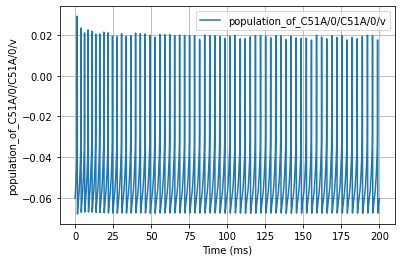

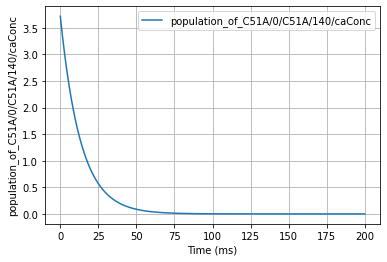

Temperature: 34.1


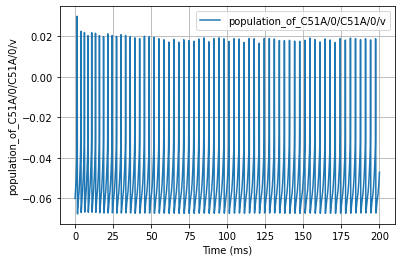

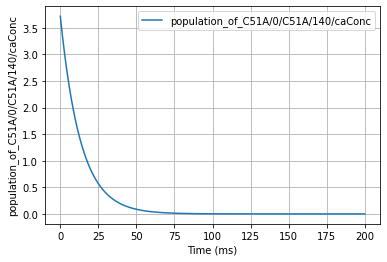

Temperature: 34.2


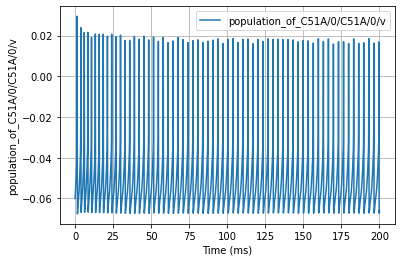

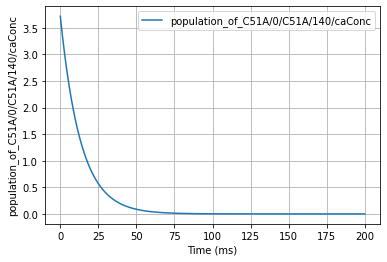

Temperature: 34.3


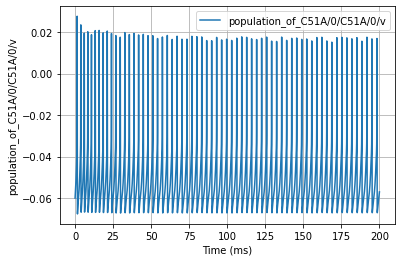

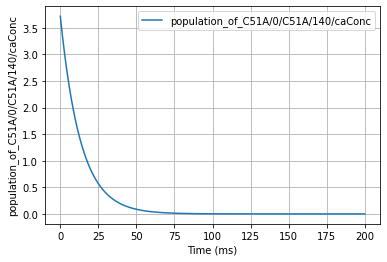

Temperature: 34.4


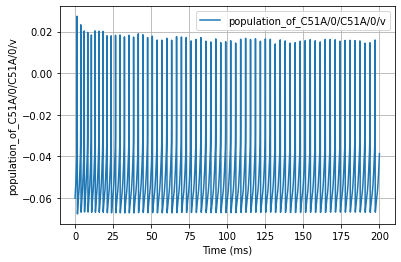

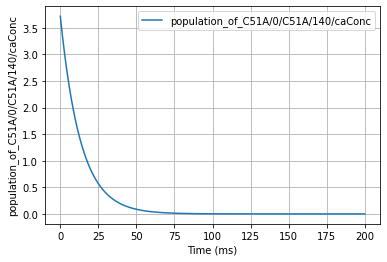

Temperature: 34.5


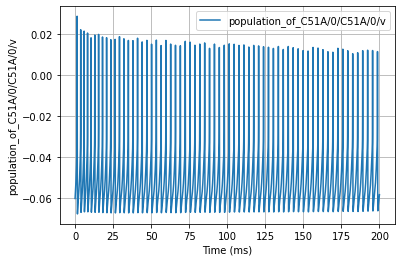

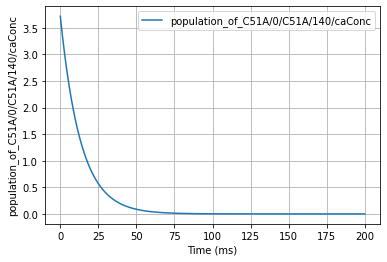

Temperature: 34.6


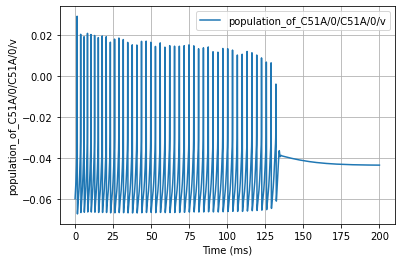

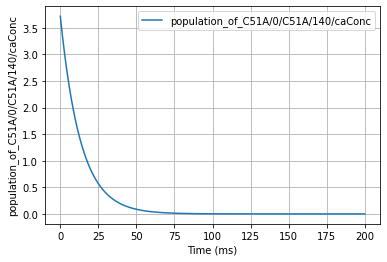

Temperature: 34.7


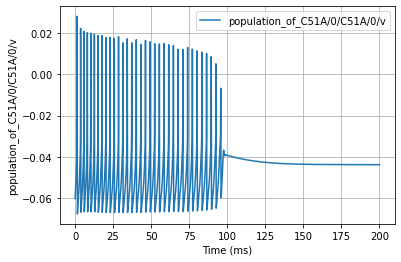

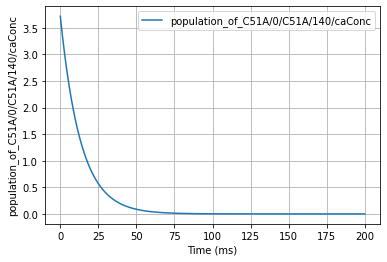

Temperature: 34.8


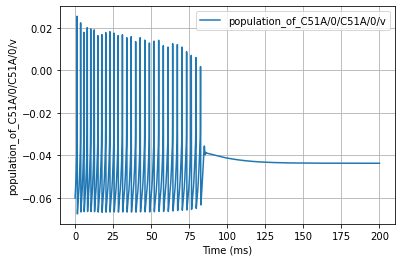

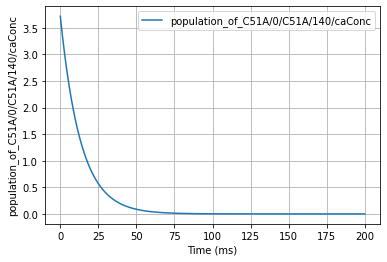

Temperature: 34.9


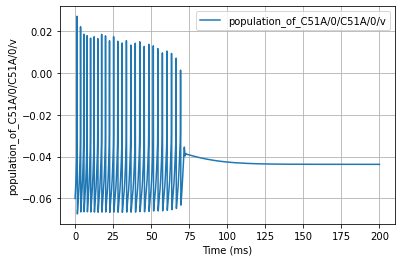

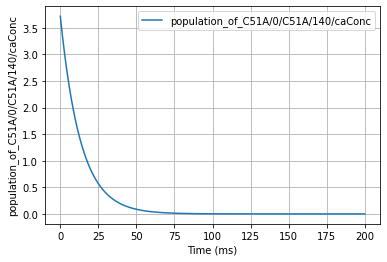

Temperature: 35.0


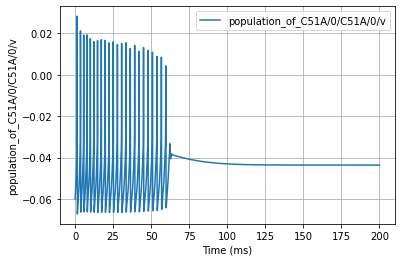

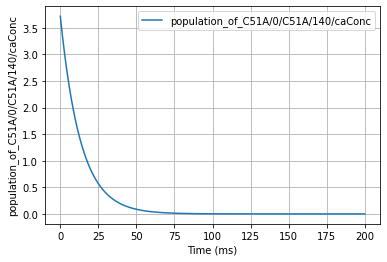

In [378]:
main()

NameError: name 'results_Neuron' is not defined